# Part III Saliency and grad-CAM (ResNet50)

In this section, we are reviewing the saliency map for CNN model which is used to make classification decision, referenced in (https://github.com/raghakot/keras-vis/blob/master/examples/resnet/attention.ipynb). To visualize activation over the final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations. We want to make the CNN model more transparent by visualizing the regions of input (two ouzels) that are ‘important’ for predictions from these models or visual explanations. The method Grad-CAM is refereced in this paper (https://arxiv.org/pdf/1610.02391v1.pdf). 

### Grad-CAM Review
Given an image, we foward propagate the image through the model to obtain the raw class scores before softmax. The gradients are set to zero for all classes except the desired class, which is set to 1. This signal is then backpropagated to the rectified convolutional feature map of interest, where we can compute the coarse Grad-CAM localization (blue heatmap). Finally, we pointwise multiply the heatmap with guided backpropagation to get Guided Grad-CAM visualizations which are both high-resolution and class-discriminative.

### ResNet50
The saliency map visualization is applied from model ResNet50, a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 50 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. The general framework of design is as follows:
- Use 3*3 filters mostly
- Down sampling with CNN layers with stride 2
- Global average pooling layer and a 1000-way fully-connected layer with Softmax in the end

In [9]:
from keras.applications import ResNet50
from vis.utils import utils
from keras import activations

# Hide warnings on Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')

# Build the ResNet50 network with ImageNet weights
model = ResNet50(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'fc1000')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

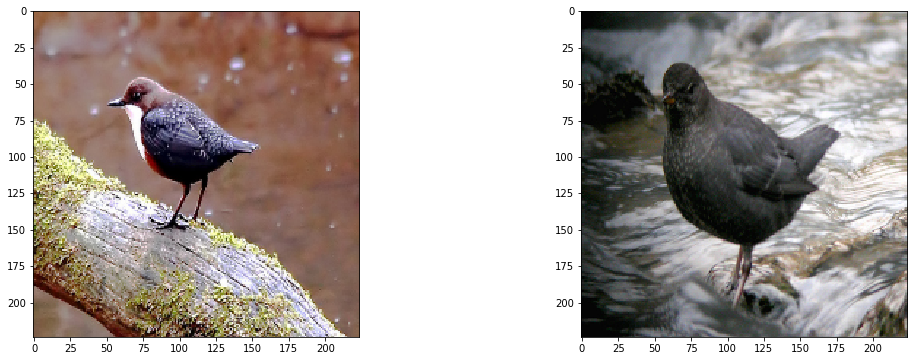

In [10]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('/Users/shilinli/Documents/GitHub/CNN-Feature-Visualization/lib/ouzel1.jpg', target_size=(224, 224))
img2 = utils.load_img('/Users/shilinli/Documents/GitHub/CNN-Feature-Visualization/lib/ouzel2.jpg', target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

After swapping the last dense layer to linear, we visualize the saliency map for the two blackbirds. Although the pictures are vague in detail texture, we could stil observe there is roughly a contour of the bird in which its color is lighter than the purple background. It seems the CNN correctly uses the lighter area for the classification problem.

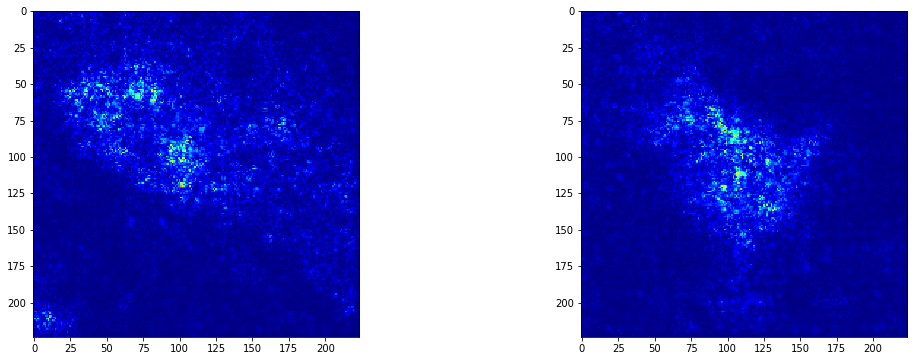

In [11]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'fc1000')

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

In order to visualize clearer for detailed saliency map, we apply the visualization for layer 'res5c_branch2c'. The Grad-CAM method contains 'vanilla', 'guided' and 'relu' in its backpropogation process. In this visualization, we only focus on the vanilla propogation. From the pictures, we could directly see the yellow area covers mostly the birds bodies that the CNN identifies the class. For models that are trained using a relevant small dataset, the network might learned the information using the background. For example, the model could classify football because of the grass and sky whereas identify a pinpong because of the table and human hands. As a result, the learning process may yield unprecise predictions and the learning process is unsuccessful. Thus, we conclude that a relative large training samples are essential for a CNN model.

<Figure size 1296x432 with 0 Axes>

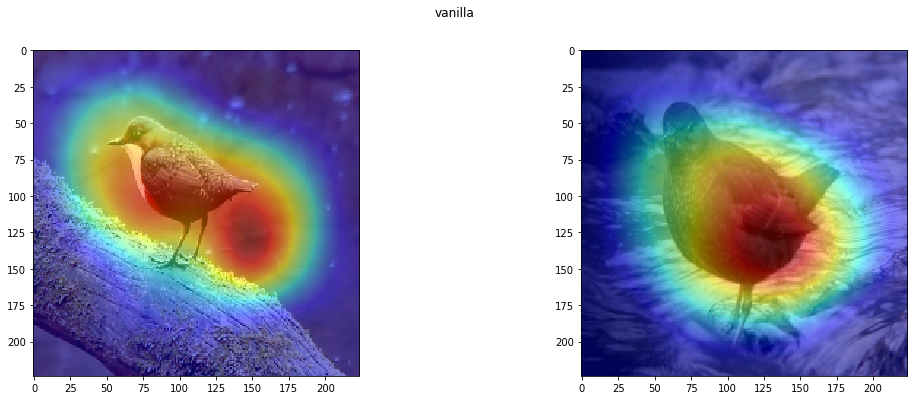

In [12]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

penultimate_layer = utils.find_layer_idx(model, 'res5c_branch2c')

for modifier in [None]:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=20, 
                              seed_input=img, penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))